<a href="https://colab.research.google.com/github/Jonny-T87/ML-Projects/blob/main/KClusterCustSeg2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#importing needed libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [5]:
#Getting data online
!wget -O Cust_Segmentation.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/Cust_Segmentation.csv

--2024-06-26 02:53:08--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/Cust_Segmentation.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34276 (33K) [text/csv]
Saving to: ‘Cust_Segmentation.csv’

Cust_Segmentation.c 100%[===================>]  33.47K  --.-KB/s    in 0.02s   

2024-06-26 02:53:09 (1.61 MB/s) - ‘Cust_Segmentation.csv’ saved [34276/34276]



In [6]:
#taking a look at data
df = pd.read_csv("Cust_Segmentation.csv")
df.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2


In [7]:
#checking data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   Address          850 non-null    object 
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 66.5+ KB


In [8]:
#checking for nan in data
df.isna().sum()

Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
Address              0
DebtIncomeRatio      0
dtype: int64

In [9]:
#checking min max and mean
df.describe()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,425.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,1.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,213.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,425.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,637.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,850.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


In [10]:
#cleaning nan from Defaulted with column mean
df['Defaulted'] = df['Defaulted'].fillna(df['Defaulted'].mean())
df.isna().sum()

Customer Id        0
Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
Address            0
DebtIncomeRatio    0
dtype: int64

In [11]:
#droping address cloumn due to being categorical and no fiting clustering model
df = df.drop('Address', axis=1)
df.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [12]:
#Normalizing data w/ StandardScaler
X = df.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 0.74291541,  0.31212243, -0.37878978, ..., -0.59048916,
        -0.65560267, -0.57652509],
       [ 1.48949049, -0.76634938,  2.5737211 , ...,  1.51296181,
        -0.65560267,  0.39138677],
       [-0.25251804,  0.31212243,  0.2117124 , ...,  0.80170393,
         1.85216712,  1.59755385],
       ...,
       [-1.24795149,  2.46906604, -1.26454304, ...,  0.03863257,
         1.85216712,  3.45892281],
       [-0.37694723, -0.76634938,  0.50696349, ..., -0.70147601,
        -0.65560267, -1.08281745],
       [ 2.1116364 , -0.76634938,  1.09746566, ...,  0.16463355,
        -0.65560267, -0.2340332 ]])

In [13]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[1 0 1 1 2 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1
 1 1 0 1 0 1 2 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1
 1 1 1 1 0 1 0 0 2 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 1 1 1 0 1 1 0 1 0 1 1 0 2 1 0 1 1 1 1 1 1 2 0 1 1 1 1 0 1 1 0 0 1 0 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1
 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 2 1 1 1 0 1 0 0 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 2
 1 1 1 1 1 1 0 1 1 1 2 1 1 1 1 0 1 2 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 0 1 

In [14]:
#making kmeans model with cluster set to 3
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)

In [15]:
#fitting kmeans cluster model to data
k_means.fit(X)

KMeans(n_clusters=3, n_init=12)

In [16]:
#Checking labels
k_means_labels = k_means.labels_
k_means_labels

array([1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [17]:
#adding label column to df
df["Clus_km"] = k_means_labels
df.head(5)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Clus_km
0,1,41,2,6,19,0.124,1.073,0.0,6.3,1
1,2,47,1,26,100,4.582,8.218,0.0,12.8,0
2,3,33,2,10,57,6.111,5.802,1.0,20.9,1
3,4,29,2,4,19,0.681,0.516,0.0,6.3,1
4,5,47,1,31,253,9.308,8.908,0.0,7.2,2


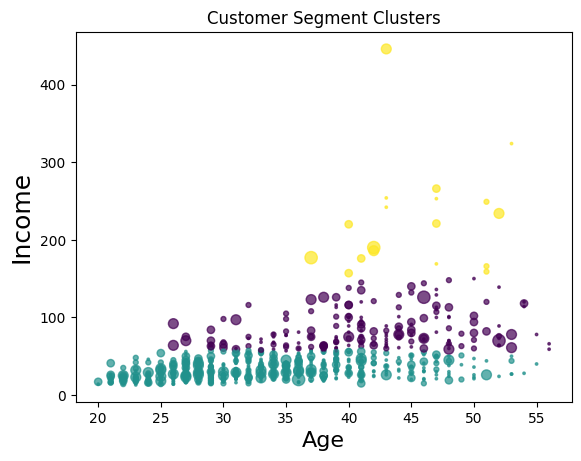

In [18]:
#plotting cluster model
c_labels = df['Clus_km']
area = np.pi * ( X[:, 1])**2

plt.scatter(X[:, 0], X[:, 3], s=area, c=c_labels.astype(float), alpha=0.7)
plt.title('Customer Segment Clusters')
plt.xlabel('Age', fontsize=16)
plt.ylabel('Income', fontsize=18)
plt.show()

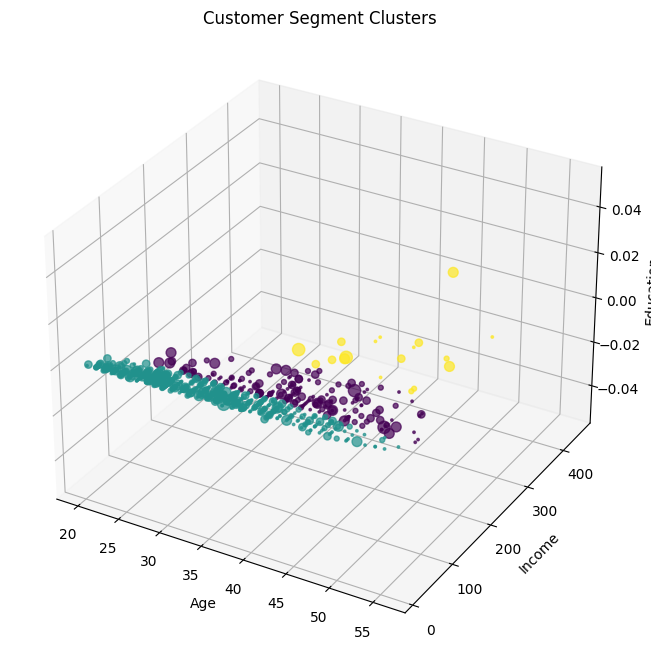

In [19]:
#plotting cluster model in 3d based Age, Income, Education
fig = plt.figure(1, figsize=(8, 9))

ax = Axes3D(fig) #fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 3], s=area, c=c_labels.astype(float), alpha=0.7)
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Education')
plt.title('Customer Segment Clusters')
plt.show()